# Quantum Neural Network Image Classifier

The present project aims to apply quantum kernels implemented with IBM’s quantum 
computing framework, Qiskit, to classify simple image patterns. Specifically, distinguishing 
between images of circles and crosses, each represented as 8x8 pixel images.

The central objective of this project is to leverage quantum kernel estimation, an innovative 
method that encodes classical data into quantum states to exploit quantum computational 
advantages, potentially enhancing classification accuracy or reducing computational 
complexity compared to classical approaches.

## Data Base

The initial stage involves the creation of an image dataset consisting of circles and crosses. This dataset will comprise a total of 60 images, subdivided into **40 training images** (20 circles and 20 crosses) and **20 testing images** (10 circles and 10 crosses). To construct this dataset, we developed the `symbols_maker.py` software, which facilitates the manual generation of freehand-drawn images on an 8x8 pixel grid. Subsequently, these images are automatically converted into binary vectors (`crosses.csv` and `circles.csv`), enabling their processing by the neural network. 


In [52]:
# Load and preprocess both CSVs
import pandas as pd
df_cross  = pd.read_csv('crosses.csv', header=None)
df_circle = pd.read_csv('circles.csv', header=None)

# Rename last column to 'Label' and map
df_cross.rename(columns={df_cross.columns[-1]: 'Label'}, inplace=True)
df_cross['Label']  = df_cross['Label'].map({1: 'Cross', 0: 'Circle'})
df_circle.rename(columns={df_circle.columns[-1]: 'Label'}, inplace=True)
df_circle['Label'] = df_circle['Label'].map({1: 'Cross', 0: 'Circle'})

# Reorder columns so 'Label' is first (avoid in‐place slice assignment)
cols_cross  = ['Label'] + [c for c in df_cross.columns  if c != 'Label']
cols_circle = ['Label'] + [c for c in df_circle.columns if c != 'Label']
df_cross  = df_cross[cols_cross]
df_circle = df_circle[cols_circle]

# Split each into first 20 rows (train) and last 10 rows (test)
train_cross, test_cross   = df_cross.iloc[:20], df_cross.iloc[20:]
train_circle, test_circle = df_circle.iloc[:20], df_circle.iloc[20:]

# Combine train/test sets
train_df = pd.concat([train_cross, train_circle], ignore_index=True)
test_df  = pd.concat([test_cross,  test_circle ], ignore_index=True)

# Extract features and labels
data_train   = train_df.drop('Label', axis=1).values
labels_train = train_df['Label'].values
data_test    = test_df .drop('Label', axis=1).values
labels_test  = test_df ['Label'].values

print(f"Train set: {len(data_train)} samples, {len(labels_train)} labels")
print(f"Test set:  {len(data_test)} samples, {len(labels_test)} labels")

Train set: 40 samples, 40 labels
Test set:  20 samples, 20 labels


## Dimensionality Reduction & Qubit Count

The following steps aim to reduce the 8×8 image data (64 features) to a smaller set of principal components and map them to qubits for quantum kernel classification.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

# Fit PCA to training data
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)

# Examine explained variance and component count
n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Selected {n_components} components, explaining {explained_variance:.2%} variance.")

Selected 21 components, explaining 95.53% variance.


## Maping the qubits

In [ ]:
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
# Se podría usar ZFeatureMap o ZZFeatureMap, habría que analizarlo.
feature_map = ZZFeatureMap(
    feature_dimension=n_components,
    reps=2,
    entanglement='full'
)

## Kernel Circuit Construction


In [55]:
import numpy as np
from qiskit import transpile
from qiskit_aer import AerSimulator
#from qiskit.utils import QuantumInstance

In [56]:
# Returns an [n1 x n2] kernel matrix by measuring the all-zero probability of the overlap circuit.
def compute_kernel_matrix(X1, X2, feature_map, backend, shots=1024):
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            # Build overlap circuit: U(x1) · U(x2)^{-1}
            qc1 = feature_map.assign_parameters(x1)
            qc2 = feature_map.assign_parameters(x2)
            overlap = qc1.compose(qc2.inverse())

            # Add measurements to capture counts
            overlap.measure_all()

            # Transpile for performance
            transpiled = transpile(overlap, backend=backend, optimization_level=3)

            # Execute and get counts
            job = backend.run(transpiled, shots=shots)
            result = job.result()
            counts = result.get_counts()

            # Probability of |0...0>
            p0 = counts.get('0' * feature_map.num_qubits, 0) / shots
            kernel[i, j] = p0
    return kernel

In [ ]:
backend = AerSimulator()
# For hardware: replace with your IBMProvider sampler

# Compute training kernel (symmetric; could optimize by half)
K_train = compute_kernel_matrix(train_pca, train_pca, feature_map, backend)

# Compute test kernel (full)
K_test = compute_kernel_matrix(test_pca, train_pca, feature_map, backend)

In [ ]:
print("K_train shape:", K_train.shape)
print("K_test shape:", K_test.shape)
print(K_test)

K_train shape: (40, 40)
K_test shape: (20, 40)
[[0.         0.         0.         0.00097656 0.         0.
  0.         0.00097656 0.         0.         0.         0.
  0.         0.         0.00097656 0.         0.00097656 0.
  0.         0.00097656 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00097656 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.00097656 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00097656 0.         0.         0.         0.00097656
  0.         0.00097656 0.         0.         0.         0.
  0.       

## SVM Training & Evaluation

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 6.1 Train the SVM using the precomputed training kernel
svc = SVC(kernel="precomputed")
svc.fit(K_train, labels_train)

# 6.2 Predict on the test kernel
labels_pred = svc.predict(K_test)

# 6.3 Evaluation metrics
accuracy = accuracy_score(labels_test, labels_pred)
conf_mat = confusion_matrix(labels_test, labels_pred)
report = classification_report(labels_test, labels_pred)

print(f"Test Accuracy: {accuracy:.2%}")
print("Confusion Matrix:")
print(conf_mat)
print("Classification Report:")
print(report)

Test Accuracy: 75.00%
Confusion Matrix:
[[ 0  5]
 [ 0 15]]
Classification Report:
              precision    recall  f1-score   support

      Circle       0.00      0.00      0.00         5
       Cross       0.75      1.00      0.86        15

    accuracy                           0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20



c:\Users\artur\Documents\Qiskit R2P\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artur\Documents\Qiskit R2P\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\artur\Documents\Qiskit R2P\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

## Visualization

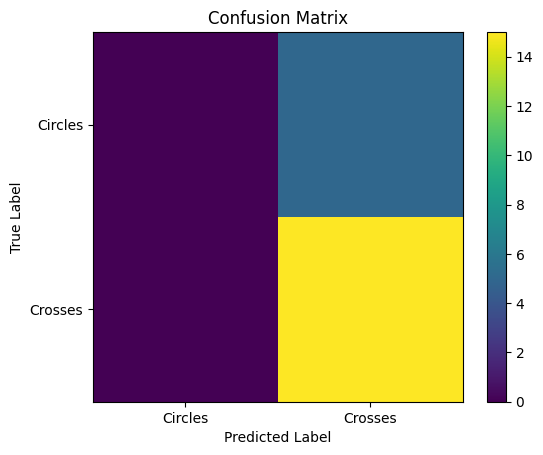

ValueError: y_true takes value in {'Circle', 'Cross'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Compute confusion matrix
conf_mat = confusion_matrix(labels_test, labels_pred)

# Plot confusion matrix
plt.figure()
plt.imshow(conf_mat)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Circles', 'Crosses'])
plt.yticks([0, 1], ['Circles', 'Crosses'])
plt.colorbar()
plt.show()

# Compute ROC curve
labels_scores = svc.decision_function(K_test)
fpr, tpr, _ = roc_curve(labels_test, labels_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')  # chance line
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()